# Mutual Information

We test the ability of a diffusion model to compute mutual information between high dimensional vectors.

**NOTE:** The variable $\varepsilon$ from the paper is named $Z$ here.

## Testing Mutual Information Using a Joint Gaussian Model

We can test the correctness of a mutual information (MI) estimator using a simple **joint Gaussian model** over high-dimensional random variables $X \in \mathbb{R}^{D_X}$, $Y \in \mathbb{R}^{D_Y}$.

We assume $X \sim \mathcal{N}(0, \Sigma_X)$ and $Z \sim \mathcal{N}(0, \Sigma_Z)$ where $Z$ is independent of $X$, and

\begin{equation*}
    Y = A X + Z, \quad A \in \mathbb{R}^{D_Y \times D_X}
\end{equation*}

That is, $Y \mid X=x \sim \mathcal{N}(Ax, \Sigma_Z)$. Then the joint vector $(X, Y) \in \mathbb{R}^{D_X + D_Y}$ is Gaussian.

### Full Covariance Matrix \( $\Sigma$ \) from First Principles

We define the joint vector

\begin{equation*}
    \begin{bmatrix}
        X \\
        Y
    \end{bmatrix}
    =
    \begin{bmatrix}
        X \\
        A X + Z
    \end{bmatrix}
\end{equation*}

$\textrm{Cov}(U,V) = \mathbb{E}[U V^\top] - \mathbb{E}[U] \mathbb{E}[V]^\top$. If $U$ and/or $V$ have mean zero the second term vanishes. Since $\mathbb{E}[X] = \mathbb{E}[Z] = 0$, we compute the covariance matrix,

\begin{equation*}
    \Sigma =
    \operatorname{Cov} \left(
        \begin{bmatrix}
            X \\
            Y
        \end{bmatrix}
    \right)
    =
    \begin{bmatrix}
        \Sigma_X & \Sigma_{XY} \\
        \Sigma_{YX} & \Sigma_Y
    \end{bmatrix}
\end{equation*}

We now derive each block,

$ \Sigma_X = \operatorname{Cov}(X, X) $

$ \Sigma_{XY} = \operatorname{Cov}(X, Y) = \mathbb{E}[X Y^\top] = \mathbb{E}[X (A X + Z)^\top] = \Sigma_X A^\top $

$ \Sigma_{YX} = \Sigma_{XY}^\top = A \Sigma_X $

$ \Sigma_Y = \operatorname{Cov}(Y, Y) = \mathbb{E}[(A X + Z)(A X + Z)^\top] = A \Sigma_X A^\top + \Sigma_Z $

Putting it all together,

\begin{equation*}
    \Sigma =
    \begin{bmatrix}
        \Sigma_X & \Sigma_X A^\top \\
        A \Sigma_X & A \Sigma_X A^\top + \Sigma_Z
    \end{bmatrix}
\end{equation*}

### Mutual Information \( $I(X; Y)$ \)

We consider two equivalent formulas for the mutual information between $X$ and $Y$.

\begin{equation*}
    I(X; Y)
        = \frac{1}{2} \log \left( \frac{|\Sigma_X| \cdot |\Sigma_Y|}{|\Sigma|} \right)
        = \frac{1}{2} \log \left( \frac{|\Sigma_Y|}{|\Sigma_{Y|X}|} \right)
\end{equation*}

where the conditional covariance of $Y$ given $X$ is

\begin{equation*}
    \Sigma_{Y|X} = \Sigma_Y - \Sigma_{YX} \Sigma_X^{-1} \Sigma_{XY}
\end{equation*}

In the present case $\Sigma_{Y|X} = \Sigma_Z$, which is apparent by direct calculation from the $\Sigma$ matrix, or using the fact that $Y|X$ is a a Gaussian with mean $A X$ and covariance $\Sigma_Z$.

**Equivalence of the Two Formulas:** The two expressions are equivalent due to the **Schur complement identity**. For a block matrix,

\begin{equation*}
    \Sigma =
    \begin{bmatrix}
        \Sigma_X & \Sigma_{XY} \\
        \Sigma_{YX} & \Sigma_Y
    \end{bmatrix}
\end{equation*}

the determinant is given by

\begin{equation*}
    |\Sigma| = |\Sigma_X| \cdot |\Sigma_Y - \Sigma_{YX} \Sigma_X^{-1} \Sigma_{XY}|
            = |\Sigma_X| \cdot |\Sigma_{Y|X}|
\end{equation*}

Therefore,

\begin{equation*}
    \frac{|\Sigma_X| \cdot |\Sigma_Y|}{|\Sigma|}
    = \frac{|\Sigma_Y|}{|\Sigma_{Y|X}|}
\end{equation*}

This confirms that both formulas yield the same mutual information.

We will also require the conditional distribution of $X \mid Y = y_{\rm d}$

\begin{equation*}
    % X \mid Y = y \sim
    p(x_{\rm d} | y_{\rm d}) =
    \mathcal{N} \left(
    x_{\rm d} ;
    \; \mu_X + \Sigma_{XY} \Sigma_{Y}^{-1} (y_{\rm d} - \mu_Y) ,
    \; \Sigma_{X} - \Sigma_{XY} \Sigma_{Y}^{-1} \Sigma_{YX}
    \right)
\end{equation*}

The distribution of $Y \mid X = x_{\rm d}$ we quoted above has a similar expression, with $X \leftrightarrow Y$, but it simplifies to $\mathcal{N}(A x_{\rm d}, \Sigma_Z)$. For the special case of $D_X=1=D_Y$, and with the $\mu_X = 0 = \mu_Y$

\begin{equation*}
    % X \mid Y = y \sim 
    p(x_{\rm d} | y_{\rm d})
    = \mathcal{N} \left(
    x_{\rm d} ;
    \; \frac{a \sigma_x^2}{a^2 \sigma_x^2 + \sigma_z^2} y_{\rm d},
    \; \frac{\sigma_x^2 \sigma_z^2}{a^2 \sigma_x^2 + \sigma_z^2}
    \right) ,
\end{equation*}

where we have taken $A=a, \Sigma_X = \sigma_x^2,$ and $\Sigma_Z = \sigma_z^2$. 

Here is some code that creates the Gaussian distribution from above. The $X$ vectors have variance

$$ \Sigma_X = B B^\top + \varepsilon I $$

where $B \sim \mathcal{N}(0, 1)^{D_X \times D_X}/\sqrt{D_X}$ is a random matrix, and $\varepsilon > 0$ ensures numerical stability and positive definiteness of $\Sigma_X$. We will train a diffusion model on the vectors $[X, Y]$ and compare the $I(X;Y)$ computed from that model with the actual value.

In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
from jax.scipy.linalg import cho_factor, cho_solve
from jax import vmap
import flax.linen as lnn
from typing import Sequence, Tuple
import distrax
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import cumulative_trapezoid, solve_ivp
import DiffusionModel as dm
import DiffusionModelImages as dmi
import TrainingUtil as tu
import GaussianMixtureUtil as gmu
from tqdm.notebook import tqdm
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from DiffusionModelImages import transport_to_data


import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

We introduce some functions to generate and visualize the Gaussian model.

In [2]:
def make_gaussian_mi_test_case(key, D_X=4, D_Y=3, noise_std=1.0, eps=1e-2):
    """Generate (X, Y) samples where Y = A X + Z with general Sigma_X and compute true I(X;Y)."""

    # Split PRNG keys
    key_A, key_B = random.split(key, 2)

    # Construct general positive definite Sigma_X = B B^T + eps I
    B = random.normal(key_B, shape=(D_X, D_X))
    B = B / jnp.sqrt(D_X) # NEW
    Sigma_X = B @ B.T + eps * jnp.eye(D_X)

    # Linear map A : R^{D_X} → R^{D_Y}
    A = random.normal(key_A, shape=(D_Y, D_X))

    # Isotropic Gaussian noise for Z
    Sigma_Z = (noise_std ** 2) * jnp.eye(D_Y)

    # Covariance of Y = A X + Z
    Sigma_Y = A @ Sigma_X @ A.T + Sigma_Z

    # True mutual information: I(X;Y) = 0.5 * log(|Sigma_Y| / |Sigma_Z|)
    logdet_Sigma_Y = jnp.linalg.slogdet(Sigma_Y)[1]
    logdet_Sigma_Z = jnp.linalg.slogdet(Sigma_Z)[1]
    mi_true = 0.5 * (logdet_Sigma_Y - logdet_Sigma_Z)

    # Full joint covariance matrix
    Sigma_XY = Sigma_X @ A.T
    Sigma_YX = A @ Sigma_X
    top = jnp.concatenate([Sigma_X, Sigma_XY], axis=1)
    bottom = jnp.concatenate([Sigma_YX, Sigma_Y], axis=1)
    Sigma_joint = jnp.concatenate([top, bottom], axis=0)

    # Zero-mean
    mu_joint = jnp.zeros(D_X + D_Y)

    # Joint distribution (X, Y)
    joint_dist = distrax.MultivariateNormalFullCovariance(loc=mu_joint, covariance_matrix=Sigma_joint)

    return joint_dist, mi_true, A, Sigma_X, Sigma_Z

Some code to test out the above function.

In [3]:
dist_key = random.PRNGKey(5) # Try 23.
samples_key = random.PRNGKey(47)
D_X = 1  # Dimensionality
D_Y = 1

dist, mi, A, Sigma_X, Sigma_Z = make_gaussian_mi_test_case(dist_key, D_X, D_Y, noise_std=1.0)
print(f"True mutual information I(X;Y): {mi:.4f} nats")

True mutual information I(X;Y): 0.1426 nats


True mutual information I(X;Y): 0.1426 nats


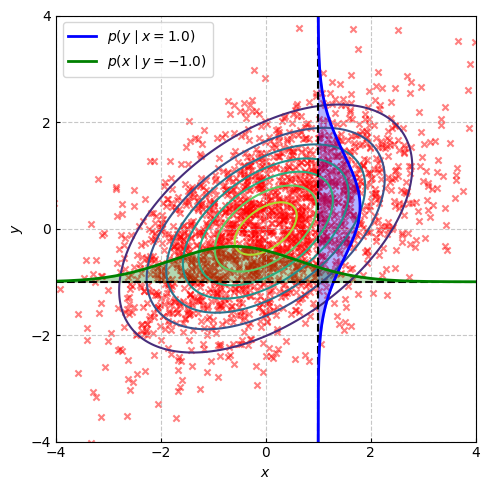

In [4]:
num_samples=2000
dist, mi_true, A, Sigma_X, Sigma_Z = make_gaussian_mi_test_case(dist_key, D_X, D_Y, noise_std=1.0)

print(f"True mutual information I(X;Y): {mi_true:.4f} nats")

samples = dist.sample(seed=samples_key, sample_shape=(num_samples,))
x = samples[:, :D_X].squeeze()
y = samples[:, D_X:].squeeze()

a = A[0, 0]
sigma_x = jnp.sqrt(Sigma_X[0, 0])
sigma_z = jnp.sqrt(Sigma_Z[0, 0])

# Fixed values
x_d = 1.0
y0 = -1.0

# p(y | x = x_d)
mu_y_given_x_d = a * x_d
sigma_y_given_x = sigma_z
y_vals = jnp.linspace(-4, 4, 300)
cond_y_pdf = distrax.Normal(loc=mu_y_given_x_d, scale=sigma_y_given_x).prob(y_vals)
cond_y_pdf *= 2.0  # scale for visual display

# p(x | y = y0)
mu_x_given_y0 = (a * sigma_x**2 / (a**2 * sigma_x**2 + sigma_z**2)) * y0
sigma_x_given_y = jnp.sqrt(sigma_x**2 * sigma_z**2 / (a**2 * sigma_x**2 + sigma_z**2))
x_vals = jnp.linspace(-4, 4, 300)
cond_x_pdf = distrax.Normal(loc=mu_x_given_y0, scale=sigma_x_given_y).prob(x_vals)
cond_x_pdf *= 2.0  # scale for visual display

# Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x, y, marker='x', s=20, alpha=0.5, color='red')

# Plot the underlying distribution
view_size = 4
x = jnp.linspace(-view_size, view_size, 300)
y = jnp.linspace(-view_size, view_size, 300)
X, Y = jnp.meshgrid(x, y)
grid_points = jnp.stack([X.ravel(), Y.ravel()], axis=-1)
probs_d = dist.prob(grid_points).reshape(X.shape)
ax.contour(X, Y, probs_d)

# p(y | x = x_d)
ax.axvline(x=x_d, color='black', linestyle='--', linewidth=1.5)
ax.plot(x_d + cond_y_pdf, y_vals, color='blue', lw=2, label=fr'$p(y \mid x = {x_d:.1f})$')
ax.fill_betweenx(y_vals, x_d, x_d + cond_y_pdf, color='blue', alpha=0.3)

# p(x | y = y0)
ax.axhline(y=y0, color='black', linestyle='--', linewidth=1.5)
ax.plot(x_vals, y0 + cond_x_pdf, color='green', lw=2, label=fr'$p(x \mid y = {y0:.1f})$')
ax.fill_between(x_vals, y0, y0 + cond_x_pdf, color='green', alpha=0.3)

# Formatting
lim = view_size
ax.set_xticks(jnp.arange(-lim, lim + 1, 2))
ax.set_yticks(jnp.arange(-lim, lim + 1, 2))
ax.tick_params(axis='both', direction='in', length=3)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.grid(True, linestyle='--', alpha=0.7)

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.legend()
plt.tight_layout()
plt.show()


## Analytic scores

In [4]:
def score_builder_joint(dmodel, gaussian_dist):
    """
    Returns a function that computes the VP score ∇_R log p(R_s, s)
    for a joint Gaussian perturbed by a VP process.

    Args:
        dmodel: object with methods
            - mu(s): sqrt(alpha(s))
            - marginal_prob_std(s): sqrt(1 - alpha(s))
        gaussian_dist: distrax.MultivariateNormalFullCovariance over (X, Y)

    Returns:
        score_fn(R_s, s): function that computes the score ∇_R log p(R_s, s)
            R_s: shape (..., D)
            s: shape (...) or scalar
            returns: same shape as R_s
    """
    Sigma = gaussian_dist.covariance()  # (D, D)
    D = Sigma.shape[0]
    I = jnp.eye(D)

    def score_joint(R, s):
        alpha = dmodel.mu(s) ** 2
        Sigma_s = alpha * Sigma + (1 - alpha) * I
        L, lower = cho_factor(Sigma_s, lower=True)
        return -cho_solve((L, lower), R)

    return vmap(score_joint, in_axes=(0, 0))  # Batched over (R_s, s)

In [5]:
def score_builder_conditional(dmodel, gaussian_dist, D_X):
    """
    Builds a score function for the conditional VP distribution p(x_s, s | y_d),
    where x_s and y_d can both be batched along axis 0.

    Args:
        dmodel: object with methods
            - mu(s): sqrt(alpha(s))
        gaussian_dist: distrax.MultivariateNormalFullCovariance over (X, Y)
        D_X: dimension of X
        D_Y: dimension of Y

    Returns:
        score_fn(x_s, y_d, s): function to compute scores
            x_s: (N, D_X)
            y_d: (N, D_Y)
            s:   (N,) or scalar
    """
    # Extract blocks from joint covariance
    Sigma = gaussian_dist.covariance()
    Sigma_X = Sigma[:D_X, :D_X]
    Sigma_Y = Sigma[D_X:, D_X:]
    Sigma_XY = Sigma[:D_X, D_X:]
    Sigma_YX = Sigma_XY.T

    # Static conditional covariance
    # linalg.solve does(A, B) does A^{-1} B.
    Sigma_X_given_Y = Sigma_X - Sigma_XY @ jnp.linalg.solve(Sigma_Y, Sigma_YX)

    def score(x, y, s):
        # x, y = r[:D_X], r[D_X:]
        alpha = dmodel.mu(s) ** 2

        Sigma_s = alpha * Sigma_X_given_Y + (1 - alpha) * jnp.eye(D_X)
        mu = jnp.sqrt(alpha) * (Sigma_XY @ jnp.linalg.solve(Sigma_Y, y))

        L, lower = cho_factor(Sigma_s, lower=True)
        return -cho_solve((L, lower), x - mu)

    return vmap(score, in_axes=(0, 0, 0))  # Batched over (x_s, y_d, s)

## Entropy rate calculation

We can compute the entropy production rate by computing the following integral by Monte Carlo:

\begin{equation*}
    S^{X|y}_{\rm tot} =
    \int_{0}^{T} {\rm d} s \,  \frac{\sigma^2}{2}
    \mathbb{E}_{{\tilde{x}_s}}
    \left[
        \left\lVert \frac{2 b_{+}}{\sigma^2} - \nabla_x \log \stackrel{\leftarrow}{p}(\tilde{X}_s, s | y) \right\rVert^2
    \right]
    =
    \int_{0}^{T} {\rm d} s \,  \frac{\sigma^2}{2}
    \mathbb{E}_{{\tilde{X}_s}}
    \left[
        \left\lVert \tilde{x}_s + \nabla_x \log \stackrel{\leftarrow}{p}(\tilde{x}_s, s | y) \right\rVert^2
    \right] .
\end{equation*}

The expectation value is taken over samples of $p_{\rm d}(x|y)$ advanced by the forward process,

\begin{equation}
    {\rm d} \tilde{X}_s = -\frac{\beta(s)}{2} \tilde{X}_s {\rm d} s + \sqrt{\beta(s)} {\rm d} \hat{B}_s ,
\end{equation}

$S^{X|y}_{\rm tot}$ is the KL between the SDEs

\begin{align*}
    {\rm d} X_t &= -(b_{+}(X_t, T-t) - \sigma^2 \nabla_x \log p(X_t, t|y)) {\rm d} t + \sigma {\rm d} B_t , \\
    {\rm d} X_t &= b_{+}(X_t, T-t) {\rm d} t + \sigma {\rm d} B_t ,
\end{align*}

where $b_{+}(X_t, T-t) = -\frac{\beta(T-t)}{2} X_t$ is the drift term restricted to the components that are not fixed. Since $\nabla \log p \approx \frac{2 b_{+}}{\sigma^2} + e_\theta$, we can approximate $S^{X|y}_{\rm tot}$ by the neural entropy

\begin{equation*}
    S^{X|y}_{\rm NN} =
    \int_{0}^{T} {\rm d} s \,  \frac{\sigma^2}{2}
    \mathbb{E}_{{\tilde{X}_s}}
    \left[
        \left\lVert e_{\bm \theta}(\tilde{x}_s, s | y) \right\rVert^2
    \right]
    =
    T \, \mathbb{E}_{s \sim \mathcal{U}(0, T)}
    \left[
        \frac{\sigma(s)^2}{2}
        \mathbb{E}_{x_{\rm d} \sim p_{\rm d}(\cdot|y)}
        \mathbb{E}_{\tilde{x}_s \sim p(\tilde{x}_s|x_{\rm d})}
        \left[
            \left\lVert e_{\bm \theta}(\tilde{x}_s, s | y) \right\rVert^2
        \right]
    \right]
\end{equation*}

where $e_{\bm \theta}(\tilde{X}_s, s | y)$ is a neural network trained with $y$ as conditioning information. That is $y$ is not diffused. So $p(\tilde{x}_s|x_{\rm d})$ is the transition kernel from the forward process above, which acts only on the $x$-component. Then,

\begin{equation*}
    \mathbb{E}_Y \left[ S^{X|y}_{\rm NN} \right] =
    T \, \mathbb{E}_{s \sim \mathcal{U}(0, T)}
    \left[
        \frac{\sigma(s)^2}{2}
        \mathbb{E}_{x_{\rm d}, y_{\rm d} \sim p_{\rm d}(\cdot, \cdot)}
        \mathbb{E}_{\tilde{x}_s \sim p(\tilde{x}_s|x_{\rm d})}
        \left[
            \left\lVert e_{\bm \theta}(\tilde{x}_s, s | y_{\rm d}) \right\rVert^2
        \right]
     \right]
\end{equation*}

Note how the expectation was taken over the conditional probability $x_{\rm d} \sim p_{\rm d}(\cdot|y)$ in the previous case, but it becomes an average over the joint distribution now, $x_{\rm d}, y_{\rm d} \sim p_{\rm d}(\cdot, \cdot)$. Therefore, we can compute $\mathbb{E}_Y \left[ S^{X|y}_{\rm NN} \right]$ with $(x_{\rm d}, y_{\rm d})$ pairs from $p_{\rm d}$. The mutual information between $X$ and $Y$ is

\begin{equation*}
    S(X) - S(X|Y) \approx \mathbb{E}_Y \left[ S^{X|y}_{\rm NN} \right] - S^{X}_{\rm NN} ,
\end{equation*}

where $S^{X}_{\rm NN}$ is the neural entropy in a diffusion model trained over the marginal $p_{\rm d}(x) = \int {\rm d} y p_{\rm d}(x,y)$.

Following [MINDE](https://arxiv.org/abs/2310.09031), we can show that the expression for mutual information simplifies to

\begin{equation*}
    S(X) - S(X|Y)
        = \int_{0}^{T} {\rm d} s \, \frac{\sigma^2}{2}
        \mathbb{E}_{Y}
        \mathbb{E}_{{\tilde{X}_s}}
        \left[
            \left\lVert \nabla_x \log p(\tilde{x}_s, s | y) - \nabla_x \log p(\tilde{x}_s, s) \right\rVert^2
        \right]
        \approx \int_{0}^{T} {\rm d} s \, \frac{\sigma^2}{2}
        \mathbb{E}_{Y}
        \mathbb{E}_{{\tilde{X}_s}}
        \left[
            \left\lVert e_{\bm \theta}(\tilde{x}_s, s | y) - e_{\bm \theta}(\tilde{x}_s, s) \right\rVert^2
        \right] .
\end{equation*}

In [6]:
def mc_entropy_rate(key, r, model, entropy_prod_rate, D_sub=None):
    eps=1e-5

    times = jnp.linspace(eps, 1, 100)
    entropy_prod_rate_arr = []

    if D_sub is None:
        D_sub = r.shape[-1]

    for time in (pbar := tqdm(times, desc='time step', leave=True)):
        key, subkey = random.split(key)
        fixed_t = jnp.ones(r.shape[0]) * time
        z = random.normal(subkey, shape=(r.shape[0], D_sub))
        std = model.marginal_prob_std(fixed_t)
        perturbed_x = r[:, :D_sub] * model.mu(fixed_t)[:, None] + z * std[:, None]
        rate = jnp.mean(entropy_prod_rate(perturbed_x, r[:, D_sub:], fixed_t))

        entropy_prod_rate_arr.append(rate)

    return entropy_prod_rate_arr, times

## Experiments

Here is the diffusion model trained on the joint Gaussian.

train iter:   0%|          | 0/200 [00:00<?, ?it/s]

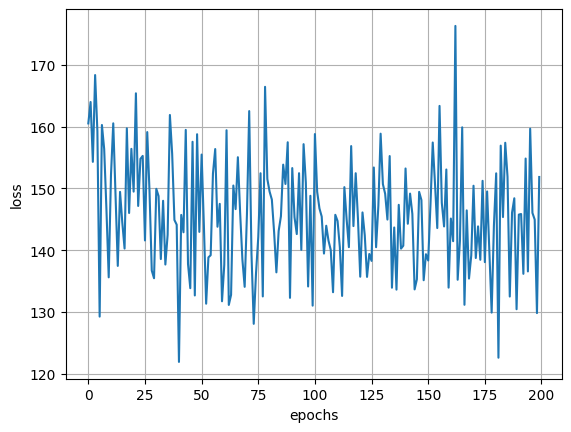

In [9]:
# Parameters
dist_key = random.PRNGKey(10)
samples_key = random.PRNGKey(47)
ml_key = random.PRNGKey(45)
num_samples = 20000
D_X = 25  # Dimensionality
D_Y = 15
D = D_X + D_Y
maxL_prefactor = True
epochs = 200
batch_size = 32

noise_std = 1.0 # Varied over 0.25, 0.6, 1.0

joint_dist, mi_true, A, Sigma_X, Sigma_Z = make_gaussian_mi_test_case(dist_key, D_X, D_Y, noise_std=noise_std)
dist_X = distrax.MultivariateNormalFullCovariance(loc=jnp.zeros(D_X), covariance_matrix=Sigma_X)

samples = joint_dist.sample(seed=samples_key, sample_shape=(num_samples,))
samples = np.asarray(samples).copy()

dmodelEM_cond = dm.DiffusionCond(features=[512, 256, D],
                                    mapping_size=256,
                                    num_dimensions=D,
                                    beta_min=0.1,
                                    beta_max=16,
                                    D_X=D_X,
                                    x_embed=False,
                                    maxL_prefactor=maxL_prefactor,
                                    grf_scale_x=10.0)
paramsEM_cond = dmodelEM_cond.init(ml_key, samples[:, :D_X], samples[:, D_X:], np.ones(samples.shape[0]))

paramsEM_cond, losses = tu.train_diffusion_with_checkpoints(key=ml_key,
                                                        model=dmodelEM_cond,
                                                        params=paramsEM_cond,
                                                        learning_rate=0.0001,
                                                        epochs=epochs,
                                                        train_dataset=dm.Data2D(samples),
                                                        batch_size=batch_size,
                                                        num_steps=10
                                                        # checkpoint_path="./files/redux/GM_2D.msgpack"
                                                        )

plt.plot(losses, label='Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)

# # A model that learns the full unconditional distribution.
# dmodelEM_joint = dm.DiffusionJoint(features=[512, 256, D],
#                                 mapping_size=256,
#                                 num_dimensions=D,
#                                 beta_min=0.1,
#                                 beta_max=16,
#                                 x_embed=False,
#                                 maxL_prefactor=maxL_prefactor,
#                                 grf_scale_x=10.0)
# paramsEM_joint = dmodelEM_joint.init(ml_key, samples, np.ones(samples.shape[0]))

# paramsEM_joint, losses = tu.train_diffusion_with_checkpoints(key=ml_key,
#                                                         model=dmodelEM_joint,
#                                                         params=paramsEM_joint,
#                                                         learning_rate=0.0001,
#                                                         epochs=epochs,
#                                                         train_dataset=dm.Data2D(samples),
#                                                         batch_size=batch_size,
#                                                         num_steps=10
#                                                         # checkpoint_path="./files/redux/GM_2D.msgpack"
#                                                         )

# plt.plot(losses, label='Training loss')
# plt.xlabel('epochs')
# plt.ylabel('loss')
# plt.grid(True)

# plt.show()

train iter:   0%|          | 0/200 [00:00<?, ?it/s]

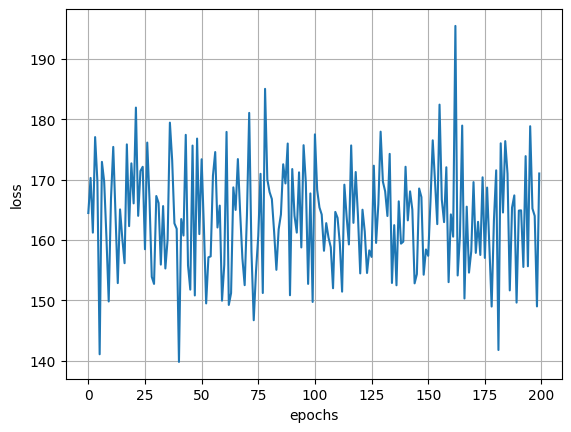

In [10]:
samples_x = dist_X.sample(seed=samples_key, sample_shape=(num_samples,))
samples_x = np.asarray(samples_x).copy()

dmodelEM_marg = dm.DiffusionJoint(features=[512, 256, D_X],
                                mapping_size=256,
                                num_dimensions=D_X,
                                beta_min=0.1,
                                beta_max=16,
                                x_embed=False,
                                maxL_prefactor=maxL_prefactor,
                                grf_scale_x=10.0)
paramsEM_marg = dmodelEM_marg.init(ml_key, samples_x, np.ones(samples_x.shape[0]))

paramsEM_marg, losses = tu.train_diffusion_with_checkpoints(key=ml_key,
                                                        model=dmodelEM_marg,
                                                        params=paramsEM_marg,
                                                        learning_rate=0.0001,
                                                        epochs=epochs,
                                                        train_dataset=dm.Data2D(samples_x),
                                                        batch_size=batch_size,
                                                        num_steps=10
                                                        # checkpoint_path="./files/redux/GM_2D.msgpack"
                                                        )

plt.plot(losses, label='Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)

The entropy profiles are calculated below with the neural and analytic scores.

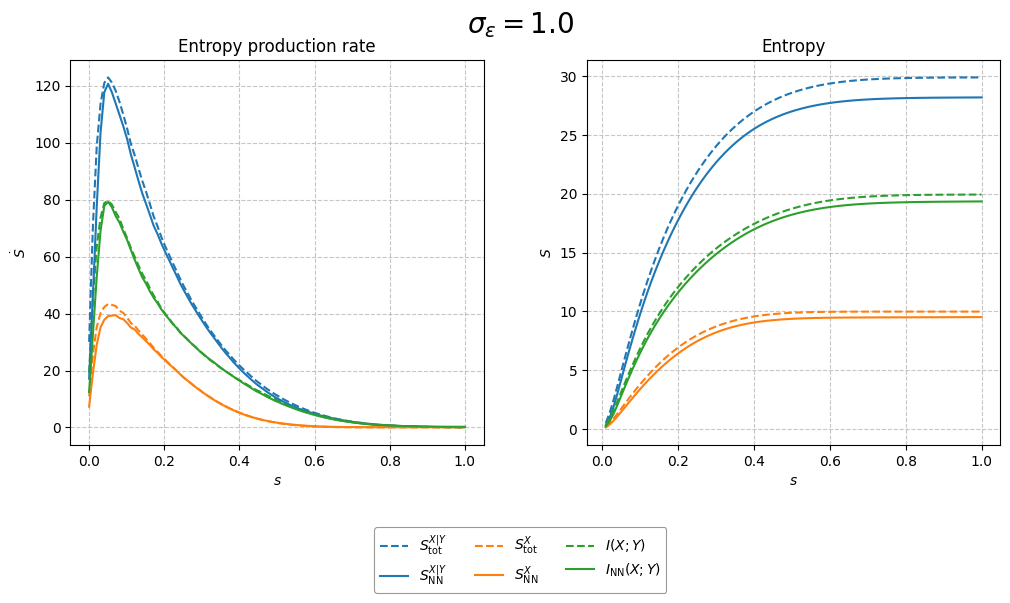

Estimated MI (Neural):   18.6782
MINDE (Neural):          19.3521
Estimated MI (Analytic): 19.9095
MINDE (Analytic):        19.9340
True MI:                 20.0422


In [ ]:
score_cond_analytic = score_builder_conditional(dmodelEM_cond, joint_dist, D_X) # \nabla_x \log p(x_s, s | y_d)
score_marg_analytic = score_builder_joint(dmodelEM_marg, dist_X) # \nabla_x \log p(x_s, s)

entropy_prod_rate_cond_analytic = lambda x, y, s : 0.5 * dmodelEM_cond.sigma_at(s)**2 * jnp.sum((dmodelEM_cond.grad_logp_eq(x, s) - score_cond_analytic(x, y, s)) ** 2, axis=-1)
entropy_prod_rate_marg_analytic = lambda x, y, s : 0.5 * dmodelEM_marg.sigma_at(s)**2 * jnp.sum((dmodelEM_marg.grad_logp_eq(x, s) - score_marg_analytic(x, s)) ** 2, axis=-1)
mutual_info_prod_rate_analytic = lambda x, y, s : 0.5 * dmodelEM_cond.sigma_at(s)**2 * jnp.sum((score_cond_analytic(x, y, s) - score_marg_analytic(x, s)) ** 2, axis=-1)

# Neural
entropy_prod_rate_cond_neural = lambda x, y, s : 0.5 * dmodelEM_cond.sigma_at(s)**2 * jnp.sum(dmodelEM_cond.apply(paramsEM_cond, x, y, s) ** 2, axis=-1)
entropy_prod_rate_marg_neural = lambda x, y, s : 0.5 * dmodelEM_marg.sigma_at(s)**2 * jnp.sum(dmodelEM_marg.apply(paramsEM_marg, x, s) ** 2, axis=-1)
mutual_info_prod_rate_neural = lambda x, y, s : 0.5 * dmodelEM_cond.sigma_at(s)**2 * jnp.sum((dmodelEM_cond.apply(paramsEM_cond, x, y, s) - dmodelEM_marg.apply(paramsEM_marg, x, s)) ** 2, axis=-1)

batch_size = 10000
key = random.PRNGKey(24)
samples_actual = joint_dist.sample(seed=key, sample_shape=(batch_size,))

key, subkey = random.split(key)

start = 0

entropy_rate_cond_analytic, times = mc_entropy_rate(key, samples_actual, dmodelEM_cond, entropy_prod_rate_cond_analytic, D_sub=D_X)
total_entropy_cond_analytic = cumulative_trapezoid(entropy_rate_cond_analytic[start:], times[start:])
entropy_rate_marg_analytic, times = mc_entropy_rate(key, samples_actual[:,:D_X], dmodelEM_marg, entropy_prod_rate_marg_analytic)
total_entropy_marg_analytic = cumulative_trapezoid(entropy_rate_marg_analytic[start:], times[start:])
mutual_info_rate_analytic, times = mc_entropy_rate(key, samples_actual, dmodelEM_cond, mutual_info_prod_rate_analytic, D_sub=D_X)
mutual_info_analytic = cumulative_trapezoid(mutual_info_rate_analytic[start:], times[start:])

entropy_rate_cond_neural, times = mc_entropy_rate(key, samples_actual, dmodelEM_cond, entropy_prod_rate_cond_neural, D_sub=D_X)
total_entropy_cond_neural = cumulative_trapezoid(entropy_rate_cond_neural[start:], times[start:])
entropy_rate_marg_neural, times = mc_entropy_rate(key, samples_actual[:,:D_X], dmodelEM_marg, entropy_prod_rate_marg_neural)
total_entropy_marg_neural = cumulative_trapezoid(entropy_rate_marg_neural[start:], times[start:])
mutual_info_rate_neural, times = mc_entropy_rate(key, samples_actual, dmodelEM_cond, mutual_info_prod_rate_neural, D_sub=D_X)
mutual_info_neural = cumulative_trapezoid(mutual_info_rate_neural[start:], times[start:])

fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes = axes.flatten()

ax = axes[0]
line_cond, = ax.plot(times[start:], entropy_rate_cond_analytic[start:], linestyle='--')
line_marg, = ax.plot(times[start:], entropy_rate_marg_analytic[start:], linestyle='--')
line_mi, = ax.plot(times[start:], mutual_info_rate_analytic[start:], linestyle='--')
ax.plot(times[start:], entropy_rate_cond_neural[start:], color=line_cond.get_color())
ax.plot(times[start:], entropy_rate_marg_neural[start:], color=line_marg.get_color())
ax.plot(times[start:], mutual_info_rate_neural[start:], color=line_mi.get_color())
ax.set_xlabel('$s$')
ax.set_ylabel('$\\dot{S}$')
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_title('Entropy production rate')

ax = axes[1]
line_cond, = ax.plot(times[start+1:], total_entropy_cond_analytic, label=r'$S^{X|Y}_{\rm tot}$', linestyle='--')
ax.plot(times[start+1:], total_entropy_cond_neural, label=r'$S^{X|Y}_{\rm NN}$', color=line_cond.get_color())
line_marg, = ax.plot(times[start+1:], total_entropy_marg_analytic, label=r'$S^{X}_{\rm tot}$', linestyle='--')
ax.plot(times[start+1:], total_entropy_marg_neural, label=r'$S^{X}_{\rm NN}$', color=line_marg.get_color())
line_mi, = ax.plot(times[start+1:], mutual_info_analytic[start:], label=r'$I(X; Y)$', linestyle='--')
ax.plot(times[start+1:], mutual_info_neural[start:], label=r'$I_{\rm NN}(X;Y)$', color=line_mi.get_color())
ax.set_xlabel('$s$')
ax.set_ylabel('$S$')
# ax.legend(loc='best')
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_title('Entropy')

fig.suptitle(fr'$\sigma_{{\varepsilon}} = {noise_std}$', fontsize=20)

# Note that the legend is filled column-first, so we have to arrange populate the plots in an interleaving way.
handles, labels = axes[1].get_legend_handles_labels()
legend = fig.legend(handles, labels,
                loc='lower center',
                bbox_to_anchor=(0.5, -0.2), # Adjust position of box
                ncol=3,
                frameon=True)
legend.get_frame().set_edgecolor('gray')
legend.get_frame().set_linewidth(0.8)

fig.subplots_adjust(wspace=0.25, hspace=0.25) # Tune the horizontal spacing.
# fig.savefig(f'files/Kelly/MIcurves_noise{noise_std}.pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"Estimated MI (Neural):   {total_entropy_cond_neural[-1] - total_entropy_marg_neural[-1]:.4f}")
print(f"MINDE (Neural):          {mutual_info_neural[-1]:.4f}")
print(f"Estimated MI (Analytic): {total_entropy_cond_analytic[-1] - total_entropy_marg_analytic[-1]:.4f}")
print(f"MINDE (Analytic):        {mutual_info_analytic[-1]:.4f}")
print(f"True MI:                 {mi_true:.4f}")

## Classifier-free guidance

We would like to understand how CFG affects mutual information. We write a version of `transport_to_data` from *DiffusionModelImages.py* that uses the modified CFG drift to generate the samples,

\begin{equation*}
    f(x, s) = -b_{+}(x,T-t) + \frac{\sigma(T-t)^{2}}{2} \Big[ (1+w)\,\nabla \log p(x, t \mid y) \;-\; w\,\nabla \log p(x, t) \Big].
\end{equation*}

In [14]:
def transport_to_data_cfg(samples, D_X, model, score_cond, score_marg, w=1.5, endtime=1, num_steps=2):
    """
    Probability flow ODE transport with classifier-free guidance.

    Args:
        samples: initial noisy samples, shape (N, D_X+D_Y)
        model: diffusion model with methods bplus(x, s) and sigma_at(s)
        score_cond: conditional score function, signature (x, y, s) -> (N, D_X)
        score_marg: marginal score function, signature (x, s) -> (N, D_X)
        w: guidance weight
        endtime: terminal time
        num_steps: number of ODE solver steps

    Returns:
        trajectory array of shape (num_steps, N, D)
    """
    t_span = (0, endtime)
    t_eval = np.linspace(*t_span, num_steps)

    shape = samples[:, :D_X].shape

    def derivative(t, x_flat):
        s = endtime - t
        x = x_flat.reshape(shape)

        s_arr = jnp.ones(shape[0]) * s

        # Compute conditional and unconditional scores
        sc = score_cond(x, y, s_arr)
        sm = score_marg(x, s_arr)

        # CFG score combination
        s_cfg = (1.0 + w) * sc - w * sm

        f = -model.bplus(x, s_arr) + 0.5 * model.sigma_at(s)**2 * s_cfg
        return f.reshape(-1,)

    x0 = samples[:, :D_X].reshape(-1,)
    y = samples[:, D_X:]
    sol = solve_ivp(derivative, t_span, x0, method='RK45', t_eval=t_eval)
    x_arr = np.transpose(sol.y).reshape(num_steps, *shape) # (num_steps, N, D_X)

    # Note: y_arr means a different thing here.
    y_arr = np.broadcast_to(y, (num_steps, *y.shape)) # (num_steps, N, D_Y)
    return np.concatenate([x_arr, y_arr], axis=-1)

When $D_X = 1 = D_Y$ we can plot the samples. We see that CFG not only squeezes the joint distribution to be tighter, it also changes the dependence of $Y$ on $X$! This experiment was done with $w=5$.

In [46]:
# Parameters
dist_key = random.PRNGKey(7)
samples_key = random.PRNGKey(47)
ml_key = random.PRNGKey(45)
num_samples = 1000
D_X = 1  # Dimensionality
D_Y = 1
D = D_X + D_Y

joint_dist, mi_true, A, Sigma_X, Sigma_Z = make_gaussian_mi_test_case(dist_key, D_X, D_Y, noise_std=1.0)
dist_X = distrax.MultivariateNormalFullCovariance(loc=jnp.zeros(D_X), covariance_matrix=Sigma_X)

samples = joint_dist.sample(seed=samples_key, sample_shape=(num_samples,))
y = samples[:, D_X:]
x0 = jax.random.normal(samples_key, (num_samples, D_X)) # Replace the x components with prior samples.
init_samples = jnp.concatenate([x0, y], axis=-1)
init_samples = np.asarray(init_samples).copy()

# A model with just the VP parameters.
dmodel_bare = dm.DiffusionBare(beta_min=0.1, beta_max=16) 

score_cond_analytic = score_builder_conditional(dmodel_bare, joint_dist, D_X) # \nabla_x \log p(x_s, s | y_d)
score_marg_analytic = score_builder_joint(dmodel_bare, dist_X) # \nabla_x \log p(x_s, s)

samples_cfg_w2 = transport_to_data_cfg(init_samples, D_X, dmodel_bare, score_cond_analytic, score_marg_analytic, w=2)[-1]
samples_cfg_w5 = transport_to_data_cfg(init_samples, D_X, dmodel_bare, score_cond_analytic, score_marg_analytic, w=5)[-1]

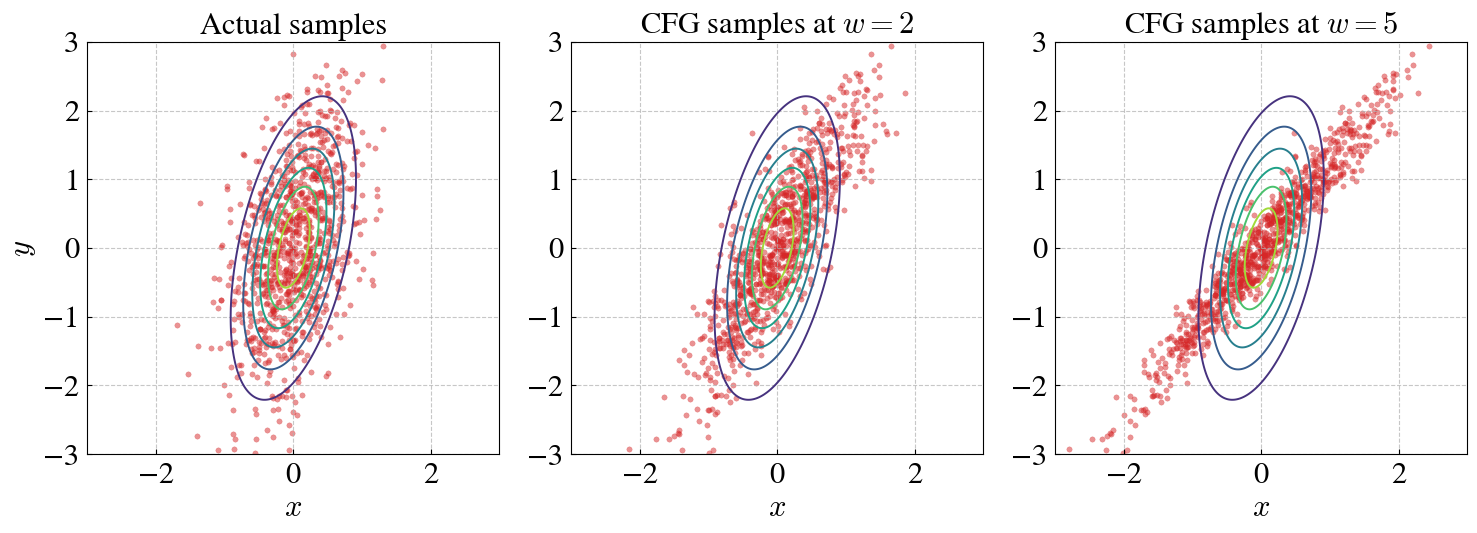

In [52]:
# Plot the solutions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

# Create a grid of points
view_size = 3
marker_size = 15
color = 'tab:red'
x = jnp.linspace(-view_size, view_size, 300)
y = jnp.linspace(-view_size, view_size, 300)
X, Y = jnp.meshgrid(x, y)
grid_points = jnp.stack([X.ravel(), Y.ravel()], axis=-1)
probs_d = joint_dist.prob(grid_points).reshape(X.shape)

ax = axes[0]
ax.contour(X, Y, probs_d)
# ax.scatter(samples_actual[:, 0], samples_actual[:, 1], s=marker_size, color=f'C0')
ax.scatter(samples[:, 0], samples[:, 1], s=marker_size, color=color, alpha=0.5) # Training samples
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim([-view_size, view_size])
ax.set_ylim([-view_size, view_size])
# ax.legend()
ax.set_title('Actual samples')
ax.grid(True, linestyle='--', alpha=0.7)
ax.tick_params(axis='both', which='both', direction='in')
ax.set_aspect('equal')

ax = axes[1]
ax.contour(X, Y, probs_d)
ax.scatter(samples_cfg_w2[:, 0], samples_cfg_w2[:, 1], s=marker_size, color=color, alpha=0.5) # Training samples
ax.set_xlabel('$x$')
# ax.set_ylabel('$y$')
ax.set_xlim([-view_size, view_size])
ax.set_ylim([-view_size, view_size])
# ax.legend()
ax.set_title(r'CFG samples at $w=2$')
ax.grid(True, linestyle='--', alpha=0.7)
ax.tick_params(axis='both', which='both', direction='in')
ax.set_aspect('equal')

ax = axes[2]
ax.contour(X, Y, probs_d)
ax.scatter(samples_cfg_w5[:, 0], samples_cfg_w5[:, 1], s=marker_size, color=color, alpha=0.5) # Training samples
ax.set_xlabel('$x$')
# ax.set_ylabel('$y$')
ax.set_xlim([-view_size, view_size])
ax.set_ylim([-view_size, view_size])
# ax.legend()
ax.set_title(r'CFG samples at $w=5$')
ax.grid(True, linestyle='--', alpha=0.7)
ax.tick_params(axis='both', which='both', direction='in')
ax.set_aspect('equal')

plt.tight_layout()
fig.savefig('files/Kelly/CFGonJointGaussian.pdf', dpi=300, bbox_inches='tight')
plt.show()

We can use a diffusion model to compute the mutual information between $Y$ and the CFG-generated $X$.

In [15]:
# Parameters
dist_key = random.PRNGKey(7)
samples_key = random.PRNGKey(47)
ml_key = random.PRNGKey(45)
num_samples = 40000
D_X = 25  # Dimensionality
D_Y = 15
D = D_X + D_Y

joint_dist, mi_true, A, Sigma_X, Sigma_Z = make_gaussian_mi_test_case(dist_key, D_X, D_Y, noise_std=1.0)
dist_X = distrax.MultivariateNormalFullCovariance(loc=jnp.zeros(D_X), covariance_matrix=Sigma_X)

samples = joint_dist.sample(seed=samples_key, sample_shape=(num_samples,))
y = samples[:, D_X:]
x0 = jax.random.normal(samples_key, (num_samples, D_X)) # Replace the x components with prior samples.
init_samples = jnp.concatenate([x0, y], axis=-1)
init_samples = np.asarray(init_samples).copy()

# A model with just the VP parameters.
dmodel_bare = dm.DiffusionBare(beta_min=0.1, beta_max=16) 

score_cond_analytic = score_builder_conditional(dmodel_bare, joint_dist, D_X) # \nabla_x \log p(x_s, s | y_d)
score_marg_analytic = score_builder_joint(dmodel_bare, dist_X) # \nabla_x \log p(x_s, s)

samples_cfg_analytic = transport_to_data_cfg(init_samples, D_X, dmodel_bare, score_cond_analytic, score_marg_analytic, w=5)[-1]

train iter:   0%|          | 0/200 [00:00<?, ?it/s]

train iter:   0%|          | 0/200 [00:00<?, ?it/s]

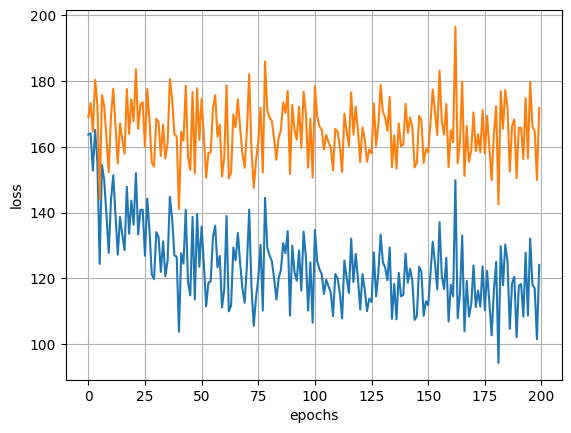

In [16]:
num_train = num_samples // 2
train_samples = samples_cfg_analytic[:num_train] # Use the first num_train to train.
test_samples = samples_cfg_analytic[num_train:]

maxL_prefactor = True
x_embed = False
batch_size = 32
epochs = 200

dmodelEM_cond_cfg = dm.DiffusionCond(features=[512, 256, D],
                                        mapping_size=256,
                                        num_dimensions=D,
                                        beta_min=0.1,
                                        beta_max=16,
                                        D_X=D_X,
                                        x_embed=x_embed,
                                        maxL_prefactor=maxL_prefactor,
                                        grf_scale_x=10.0)
paramsEM_cond_cfg = dmodelEM_cond_cfg.init(ml_key, train_samples[:, :D_X], train_samples[:, D_X:], np.ones(train_samples.shape[0]))

paramsEM_cond_cfg, losses = tu.train_diffusion_with_checkpoints(key=ml_key,
                                                        model=dmodelEM_cond_cfg,
                                                        params=paramsEM_cond_cfg,
                                                        learning_rate=0.0001,
                                                        epochs=epochs,
                                                        train_dataset=dm.Data2D(train_samples),
                                                        batch_size=batch_size,
                                                        num_steps=10
                                                        # checkpoint_path="./files/redux/GM_2D.msgpack"
                                                        )

plt.plot(losses, label='Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)

train_samples_x = train_samples[:, :D_X]

dmodelEM_marg_cfg = dm.DiffusionJoint(features=[512, 256, D_X],
                                mapping_size=256,
                                num_dimensions=D_X,
                                beta_min=0.1,
                                beta_max=16,
                                x_embed=x_embed,
                                maxL_prefactor=maxL_prefactor,
                                grf_scale_x=10.0)
paramsEM_marg_cfg = dmodelEM_marg_cfg.init(ml_key, train_samples_x, np.ones(train_samples_x.shape[0]))

paramsEM_marg_cfg, losses = tu.train_diffusion_with_checkpoints(key=ml_key,
                                                        model=dmodelEM_marg_cfg,
                                                        params=paramsEM_marg_cfg,
                                                        learning_rate=0.0001,
                                                        epochs=epochs,
                                                        train_dataset=dm.Data2D(train_samples_x),
                                                        batch_size=batch_size,
                                                        num_steps=10
                                                        # checkpoint_path="./files/redux/GM_2D.msgpack"
                                                        )

plt.plot(losses, label='Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.show()


In [17]:
mutual_info_prod_rate_analytic = lambda x, y, s : 0.5 * dmodelEM_cond_cfg.sigma_at(s)**2 * jnp.sum((score_cond_analytic(x, y, s) - score_marg_analytic(x, s)) ** 2, axis=-1)
mutual_info_prod_rate_neural = lambda x, y, s : 0.5 * dmodelEM_cond_cfg.sigma_at(s)**2 * \
    jnp.sum((dmodelEM_cond_cfg.apply(paramsEM_cond_cfg, x, y, s) - dmodelEM_marg_cfg.apply(paramsEM_marg_cfg, x, s)) ** 2, axis=-1)

test_samples_analytic = samples[num_train:] # Use original sample, not CFG ones for analytic MI.

key = random.PRNGKey(24)
start = 0
mutual_info_rate_analytic, times = mc_entropy_rate(key, test_samples_analytic, dmodelEM_cond_cfg, mutual_info_prod_rate_analytic, D_sub=D_X)
mutual_info_analytic = cumulative_trapezoid(mutual_info_rate_analytic[start:], times[start:])
mutual_info_rate_neural, times = mc_entropy_rate(key, test_samples, dmodelEM_cond_cfg, mutual_info_prod_rate_neural, D_sub=D_X)
mutual_info_neural = cumulative_trapezoid(mutual_info_rate_neural[start:], times[start:])


print(f"MI from CFG by MINDE:    {mutual_info_neural[-1]:.4f}")
print(f"MINDE (Analytic):        {mutual_info_analytic[-1]:.4f}")
print(f"True MI:                 {mi_true:.4f}")


time step:   0%|          | 0/100 [00:00<?, ?it/s]

time step:   0%|          | 0/100 [00:00<?, ?it/s]

MI from CFG by MINDE:    44.6023
MINDE (Analytic):        18.3295
True MI:                 18.3365
